In [2]:
# Add PyDatAnalysis to path
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "/Users/owensheekey/Documents/Research/PyDatAnalysis")

export_path = 'Exports/'


In [3]:
from __future__ import annotations
from progressbar import progressbar
from src.DatObject.Make_Dat import get_dat, get_dats
import src.UsefulFunctions as U
from src.DataStandardize.ExpSpecific.Feb21 import Feb21Exp2HDF, Feb21ExpConfig
from src.DataStandardize.ExpConfig import ExpConfigGroupDatAttribute, ExpConfigBase
import multiprocessing as mp
import plotly.graph_objs as go
import numpy as np
import lmfit as lm
from typing import TYPE_CHECKING, Iterable, Optional
from src.DatObject.Attributes.Transition import i_sense_digamma, i_sense, i_sense_digamma_quad
from src.UsefulFunctions import edit_params
from src.DatObject.Attributes.SquareEntropy import square_wave_time_array, integrate_entropy
import logging
logger = logging.getLogger(__name__)
import src.UsefulFunctions as U
from src.CoreUtil import decimate

In [4]:
def narrow_fit(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    out = dat.SquareEntropy.get_Outputs(existing_only=True)
    x = np.copy(out.x)
    y = np.copy(out.averaged)
    y = np.mean(y[(0, 2), :], axis=0)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [5]:
def narrow_fit_trans_only(dat, width, **kwargs):
    '''
    Get a fit only including +/- width in dat.x around center of transition
    kwargs is the stuff to pass to get_fit
    Return a fit
    '''
    x = np.copy(dat.Transition.avg_x)
    y = np.copy(dat.Transition.avg_data)

    start_ind = np.nanargmin(np.abs(np.add(x, width)))
    end_ind = np.nanargmin(np.abs(np.subtract(x, width)))

    x[:start_ind] = [np.nan] * start_ind
    x[end_ind:] = [np.nan] * (len(x) - end_ind)

    y[:start_ind] = [np.nan] * start_ind
    y[end_ind:] = [np.nan] * (len(y) - end_ind)

    fit = dat.SquareEntropy.get_fit(
        x=x,
        data=y,
        **kwargs)
    return fit

In [6]:
def do_calc(datnum, overwrite=True):
    """Just a function which can be passed to a process pool for faster calculation"""
    save_name = 'SPS.01'

    dat = get_dat(datnum)

    setpoints = [0.01, None]

    # Get other inputs
    setpoint_times = square_wave_time_array(dat.SquareEntropy.square_awg)
    sp_start, sp_fin = [U.get_data_index(setpoint_times, sp) for sp in setpoints]
    logger.debug(f'Setpoint times: {setpoints}, Setpoint indexs: {sp_start, sp_fin}')

    # Run Fits
    pp = dat.SquareEntropy.get_ProcessParams(name=None,  # Load default and modify from there
                                             setpoint_start=sp_start, setpoint_fin=sp_fin,
                                             transition_fit_func=i_sense,
                                             save_name=save_name)
    out = dat.SquareEntropy.get_Outputs(name=save_name, inputs=None, process_params=pp, overwrite=overwrite)
    dat.Entropy.get_fit(which='avg', name=save_name, data=out.average_entropy_signal, x=out.x, check_exists=False,
                        overwrite=overwrite)
    [dat.Entropy.get_fit(which='row', row=i, name=save_name,
                         data=row, x=out.x, check_exists=False,
                         overwrite=overwrite) for i, row in enumerate(out.entropy_signal)]
    return out

In [7]:
def get_deltaT(dat):
    """Returns deltaT of a given dat in mV"""
    ho1 = dat.AWG.max(0)  # 'HO1/10M' gives nA * 10
    t = dat.Logs.temps.mc

    # Datnums to search through (only thing that should be changed)
    datnums = set(range(2143, 2156))
    # datnums = set()
    # for j in range(5):
    #     datnums = datnums.union(set(range(28 * j + 1312, 28 * j + 1312 + 4 * 7 + 1)) - set([28 * j + 1312 + 4 * i for i in range(8)]))
    # datnums = list(datnums)

    dats = get_dats(datnums)

    dats = [d for d in dats if np.isclose(d.Logs.temps.mc, dat.Logs.temps.mc, rtol=0.1)]  # Get all dats where MC temp is within 10%
    bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])

    indp = np.argmin(abs(bias_lookup - ho1))
    indm = np.argmin(abs(bias_lookup + ho1))
    theta_z = np.nanmean([d.Transition.avg_fit.best_values.theta for d in dats if d.Logs.fds['HO1/10M'] == 0])

    # temp_lookup = np.array([d.Logs.temps.mc for d in dats])
    # bias_lookup = np.array([d.Logs.fds['HO1/10M'] for d in dats])
    #
    # indp = np.argmin(temp_lookup - t + bias_lookup - ho1)
    # indm = np.argmin(temp_lookup - t + bias_lookup + ho1)
    # indz = np.argmin(temp_lookup - t + bias_lookup)

    theta_p = dats[indp].Transition.avg_fit.best_values.theta
    theta_m = dats[indm].Transition.avg_fit.best_values.theta
    # theta_z = dats[indz].Transition.avg_fit.best_values.theta
    return (theta_p + theta_m) / 2 - theta_z

In [51]:
# datnums = set(range(1869, 1919)) - set(range(1870, 1919, 2))
# transdatnums = set(range(1869, 1919)) - set(range(1869, 1919, 2))

# datnums = np.sort(list(set(range(2089, 2095)) - set(range(2090, 2095, 2))))
# transdatnums = np.sort(list(set(range(2089, 2095)) - set(range(2089, 2095, 2))))
# datnums = np.sort(list(set(range(1778, 1795))))

# datnums = np.sort(list(set(range(2156, 2162)) - set(range(2157, 2162, 2))))
# transdatnums = np.sort(list(set(range(2156, 2162)) - set(range(2156, 2162, 2))))

datnums = [2164,2167, 2170, 2176, 2160, 2131, 2178, 2180, 2182]
transdatnums = [2165,2168, 2171, 2177, 2161, 2132, 2179, 2181, 2183]

# datnums = np.sort(list(set(range(2095, 2143)) - set(range(2096, 2143, 2))))
# transdatnums = np.sort(list(set(range(2095, 2143)) - set(range(2095, 2143, 2))))
end = 2806
datnums = np.sort(list(set(range(2659, end)) - set(range(2660, end, 2)) - set([2793])))
transdatnums = np.sort(list(set(range(2659, end)) - set(range(2659, end, 2)) - set([2794])))
# datnums = np.array([2699, 2719, 2731, 2737, 2741, 2757])
# transdatnums = np.add(datnums, 1)
#datnums = np.sort(list(set(range(3066, 3255+1))))
datnums = np.sort(list(set(range(3451, 3551+1))))
#datnums = np.sort(list(set(range(3085, 3244+1)) | set(range(3430, 3450+1))))
#datnums = np.sort(list(set(range(3551, 3652+1))))
datnums = np.sort(list(set(range(3671, 3698+1))))
datnums = np.sort(list(set(range(3769, 3890+1))))
datnums = np.sort(list(set(range(3931, 3947+1))))
datnums = np.sort(list(set(range(3985, 4015+1))))
# datnums = np.sort(list(set(range(4017, 4047+1)) | set(range(4090, 4098+1))))
# datnums = np.sort(list(set(range(4049, 4078+1)) | set(range(4099, 4106+1))))
datnums = np.sort(list(set(range(4118, 4198+1))))
datnums = np.sort(list(set(range(4238, 4318+1))))
datnums = np.sort(list(set(range(4435, 4455+1))))
datnums = np.sort(list(set(range(4468, 4494+1))))
datnums = np.sort(list(set(range(4500, 4553+1))))
# datnums = np.sort(list(set(range(4555, 4608+1))))
# datnums = np.sort(list(set(range(4610, 4654+1))))
datnums = np.sort(list(set(range(4668, 4721+1))))
# datnums = np.sort(list(set(range(4723, 4776+1))))
# datnums = np.sort(list(set(range(4783, 4820+1))))
# datnums = np.sort(list(set(range(4847, 4867+1))))
# datnums = np.sort(list(set(range(4987, 5004+1))))
# datnums = np.sort(list(set(range(4987, 5004+1))))
# # datnums = np.sort(list(set(range(5006, 5014+1))))
# # # datnums = np.sort(list(set(range(5016, 5024+1))))
# # # datnums = np.sort(list(set(range(5026, 5034+1))))
# # # datnums = np.sort(list(set(range(5036, 5044+1))))
# # # datnums = np.sort(list(set(range(5046, 5054+1))))
# # datnums = np.sort(list(set(range(5056, 5072+1))))
# # datnums = np.sort(list(set(range(5056, 5072+1))))
# # datnums = np.sort(list(set(range(5074, 5090+1))))
# # # datnums = np.sort(list(set(range(5092, 5108+1))))
# # # datnums = np.sort(list(set(range(5110, 5126+1))))
# # # datnums = np.sort(list(set(range(5128, 5144+1))))
# # datnums = np.sort(list(set(range(5146, 5162+1))))
# # datnums = np.sort(list(set(range(5164, 5180+1))))
# # datnums = np.sort(list(set(range(5182, 5198+1))))
# # datnums = np.sort(list(set(range(5200, 5216+1))))
# # datnums = np.sort(list(set(range(5218, 5234+1))))
datnums = np.sort(list(set(range(5602, 5626+1))))
datnums = np.sort(list(set(range(5628, 5652+1))))
datnums = np.sort(list(set(range(5681, 5691+1))))
datnums = np.sort([850, 863, 875, 892, 918, 928, 948, 960, 972, 984])

In [71]:
dats = get_dats(list(datnums), overwrite=False)
temps = [250, 225, 200, 175, 125, 100, 75, 50, 30, 10]
# transdats = get_dats(list(transdatnums), overwrite=False) \\np.mean(dat.Data.sweepgates_x[1][1:])
# ips = [np.mean(dat.Data.sweepgates_x[1][1:]) for dat in dats]

In [35]:
dats[0].Logs.fds

{'ACC/100': 999.79,
 'CSQ': -248.41,
 'ESC': -249.94,
 'ESP': -467.22,
 'ESS': -429.99,
 'HO1': 0,
 'HO2': 0,
 'csbias/100': -31.128}

In [48]:
# Θ = np.average([dat.SquareEntropy.get_fit(which='avg',which_fit='transition', transition_part='cold', check_exists=False).best_values.theta for dat in progressbar(dats)])
fit = dats[0].Transition.get_fit(which='avg', check_exists=False)
Θ = 2.2
params = fit.params
params.add('g', value=0, vary=False, min=-50, max=1000)
new_pars = edit_params(params, param_name='theta', value=Θ, vary=True)

In [31]:
amp_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    which='avg', 
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.amp
for dat in progressbar(transdats)]

NameError: name 'transdats' is not defined

In [49]:
g_digamma_ = [narrow_fit_trans_only(
    dat,
    500,
    initial_params=new_pars, 
    fit_func=i_sense_digamma, 
    check_exists=False).best_values.g
for dat in progressbar(transdats)]

NameError: name 'transdats' is not defined

In [53]:
theta_digamma_ = [dat.Transition.get_fit(which='avg', check_exists=False, overwrite=True, initial_params=new_pars, fit_func=i_sense_digamma).best_values.theta
for dat in progressbar(dats)]

100% (10 of 10) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [128]:
fig = go.Figure()

fig.add_trace(go.Scatter(mode='markers', x=temps, y=theta_digamma_, name="Thetas"))
fit = np.polyfit(temps[:-2], theta_digamma_[:-2], 1)
fig.add_trace(go.Scatter(mode='lines', x=temps, y=np.polyval(fit, temps), name="Fit"))


fig.update_layout(xaxis_title='Temp /mK', yaxis_title='Theta /mV',
                      title=f'Dats {dats[0].datnum} - {dats[-1].datnum}')
fig.show(renderer="chrome")

In [60]:
fit

array([0.03989062, 0.34983446])

In [73]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

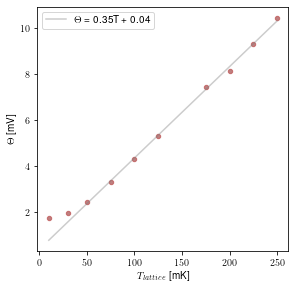

In [131]:
plt.scatter(temps, theta_digamma_, marker="o", alpha=0.5, s=20, c='maroon', edgecolors="firebrick", label=None)

plt.plot(temps, np.polyval(fit, temps), c='grey', alpha=0.4, label=r'$\Theta$' + f' = {fit[1]:0.2f}T + {fit[0]:0.2f}')
plt.xlabel(r'$T_{lattice}$' + ' [mK]')
plt.ylabel(r'$\Theta$ [mV]')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(4.5, 4.5)
fig.savefig(f'Exports/thesis_presentation/e_temp1.pdf', format='pdf')

In [87]:
dats[0].Transition.avg_data

array([nan, nan, nan, ..., nan, nan, nan])

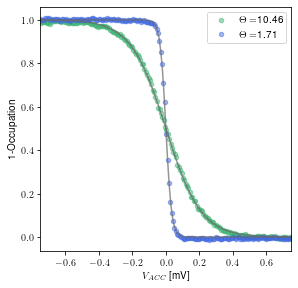

In [126]:
colors = ["mediumseagreen", "royalblue"]
for j, i in enumerate([0,9]):
    fit = dats[i].Transition.get_fit(which='avg', check_exists=False, overwrite=True, initial_params=new_pars, fit_func=i_sense_digamma)
    xfit = np.linspace(-200,200,401)
    yfit = (1/fit.best_values.amp) * (fit.eval_fit(xfit) - fit.best_values.const - xfit*fit.best_values.lin) + 0.5
    x = dats[i].Transition.avg_x[15000:-20000:20]
    y = (1/fit.best_values.amp) * (dats[i].Transition.avg_data[15000:-20000:20] - fit.best_values.const - x*fit.best_values.lin) + 0.5
    plt.xlim(-0.75,0.75)
    label = r'$\Theta = $' + f'{fit.best_values.theta:.2f}'
    plt.scatter(x/100, y, marker="o", alpha=0.5, s=20, color=colors[j], label=label)
    plt.plot(xfit/100, yfit, c='dimgrey', alpha=0.7, label=None)

plt.xlabel(r'$V_{ACC}$' + ' [mV]')
plt.ylabel(r'1-Occupation')
plt.legend()   
fig = plt.gcf()
fig.set_size_inches(4.5, 4.5)
fig.savefig(f'Exports/thesis_presentation/e_temp2.pdf', format='pdf')

In [94]:
len()

48780